In [1]:
from FlightMLP import FlightMLP
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from FlightDataset import FlightDataset

Get data:

In [2]:
data = np.load('../data/airline_final.npy')
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

test_dataset = FlightDataset(torch.tensor(test_data))
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
test_data = None

X = test_dataset.data[:, :-1]
y = test_dataset.data[:,-1]

In [3]:

def parse_params(file_name):
    '''
    parse out layers, dropout, and learning rate
    '''
    
    # remove file extension
    idx = file_name[::-1].find('.')
    file_name = file_name[:-idx - 1]
    
    # remove prefix
    file_name = file_name[file_name.find('_')+1:]

    # get lr
    idx = file_name[::-1].find('_')
    lr = float(file_name[-idx:])
    file_name = file_name[:-idx]
    file_name = file_name.strip('_lr_')

    if 'drop' in file_name:
        dropout = True
        file_name = file_name.strip('_drop')
    else:
        dropout = False

    layers = file_name.split('_')
    layers = [int(l) for l in layers]

    return layers, lr, dropout

In [24]:
weights = os.listdir('weights/')
models = []
params = []

columns=[
    'hidden layers', 
    'hidden nodes', 
    'lr', 
    'dropout',
    'accuracy',
    'precision',
    'recall',
    'f1',
    'auc'
]


results = pd.DataFrame(columns=columns)
roc_list = []

for i, file in enumerate(weights):
    layers, lr, dropout = parse_params(file)
    params.append([layers, lr, dropout])
    model = FlightMLP(layer_sizes=layers, dropout=dropout)
    model.load_state_dict(torch.load('weights/' + file))
    models.append(model)
    
    model.eval()
    X = test_dataset.data[:,:-1].float()
    y = test_dataset.data[:,-1].float()
    y_pred_score = torch.sigmoid(model(X)).detach().numpy()
    y_pred = y_pred_score >= 0.5
    
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    roc = roc_curve(y, y_pred_score)
    roc_list.append(roc)
    
    precision, recall, f, support = precision_recall_fscore_support(y, y_pred)
    precision = precision[1]
    recall = recall[1]
    f1 = f[1]
    
    data = {
        'hidden layers' : len(layers),
        'hidden nodes' : layers[0],
        'lr' : lr,
        'dropout' : dropout,
        'accuracy' : accuracy,
        'precision' : precision,
        'recall' : recall,
        'f1' : f1,
        'auc' : auc
    }
    
    results.loc[i] = data
    

[200] 0.0001 False
0.7371472361976477 0.48381984987489574 0.7733635515264632 [0.80537807 0.59524909] 0.74922175444127

[20, 20, 20] 1e-05 True
0.7381134841568654 0.48481515946197445 0.7640314624716704 [0.80689858 0.59320981] 0.7467545372059845

[100] 0.0001 True
0.74990837303835 0.4997769251360757 0.7467004399413412 [0.81833583 0.59878127] 0.7488388482578063

[200, 200, 200] 0.0001 False
0.6976310265551594 0.4432670126874279 0.8197573656845754 [0.76521874 0.57539887] 0.7383479436809515

[50, 50] 1e-05 False
0.740445806817046 0.4880053125259401 0.7837621650446607 [0.80754978 0.60149376] 0.7548874791108164

[200, 200, 200] 1e-05 False
0.7436111018558624 0.4913961326946958 0.738568190907879 [0.81345907 0.59014647] 0.7419297955250127

[50] 0.001 True
0.7673674740945591 0.5245482924983446 0.739234768697507 [0.83357963 0.61365649] 0.7579880311149227

[20, 20] 1e-05 False
0.7603038683237264 0.5140272320204697 0.7499000133315558 [0.82699245 0.60995446] 0.7568352234390543

[100, 100] 0.0001 Fal

In [25]:
results

,hidden layers,hidden nodes,lr,dropout,accuracy,precision,recall,f1,auc
0,1,200,0.00010,False,0.737147,0.483820,0.773364,0.595249,0.749222
1,3,20,0.00001,True,0.738113,0.484815,0.764031,0.593210,0.746755
2,1,100,0.00010,True,0.749908,0.499777,0.746700,0.598781,0.748839
3,3,200,0.00010,False,0.697631,0.443267,0.819757,0.575399,0.738348
4,2,50,0.00001,False,0.740446,0.488005,0.783762,0.601494,0.754887
...,...,...,...,...,...,...,...,...,...
61,1,100,0.00100,True,0.752474,0.503278,0.736835,0.598063,0.747260
62,2,100,0.00001,False,0.767134,0.524219,0.738702,0.613248,0.757655
63,1,30,0.00010,True,0.733515,0.479407,0.771231,0.591271,0.746090
64,3,20,0.00100,True,0.754373,0.505650,0.769497,0.610277,0.759416


In [27]:
results.sort_values('auc')

,hidden layers,hidden nodes,lr,dropout,accuracy,precision,recall,f1,auc
19,3,100,0.00010,False,0.663846,0.415458,0.847754,0.557636,0.725161
32,3,100,0.00001,False,0.680372,0.428766,0.839355,0.567591,0.733377
39,3,20,0.00100,False,0.707260,0.451003,0.788428,0.573785,0.734322
55,1,30,0.00100,True,0.728784,0.473054,0.747767,0.579502,0.735113
46,1,30,0.00010,False,0.722853,0.466710,0.763498,0.579304,0.736404
...,...,...,...,...,...,...,...,...,...
8,2,100,0.00010,False,0.779229,0.544019,0.720837,0.620069,0.759761
49,3,200,0.00001,True,0.786159,0.556791,0.707772,0.623268,0.760025
18,3,20,0.00010,False,0.743778,0.492183,0.793228,0.607453,0.760264
59,3,50,0.00010,True,0.775964,0.538085,0.731769,0.620156,0.761229


Text(0, 0.5, 'TPR')

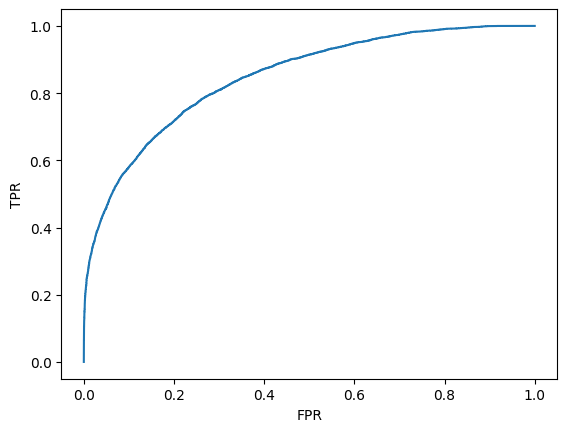

In [28]:
roc = roc_curve(y, y_pred)
plt.plot(roc_list[23][0], roc_list[23][1])
plt.xlabel('FPR')
plt.ylabel('TPR')